[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/classification/ensemble.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# Ensemble methods

This notebook tackles two important things: ensemble methods and how to compare the performance of different models. Ensemble methods are a type of machine learning technique that combines several models to improve the performance of the model. To compare the performance of different models, we have to used statistical tests, since the models are trained with stochastic procedures.

We use the [Titanic Disaster dataset](https://www.kaggle.com/c/titanic/data?select=test.csv) stored in `data/titanic.csv`. The dataset has de following features:
- PassengerId: unique identifier for each passenger.
- Survived: target variable (0 = No, 1 = Yes).
- Pclass: ticket class (1 = 1st, 2 = 2nd, 3 = 3rd).
- Name: name of the passenger.
- Sex: "male" or "female".
- Age: age in years.
- SibSp: number of siblings/spouses aboard.
- Parch: number of parents/children aboard.
- Ticket: ticket number.
- Fare: passenger fare.
- Cabin: cabin number.
- Embarked: port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

In [39]:
# make sure the required packages are installed
%pip install pandas seaborn matplotlib scikit-learn xgboost --quiet
repo='data-science-course'
module='classification'
# if running in colab, install the required packages and copy the necessary files
if get_ipython().__class__.__module__.startswith('google.colab'):
    import os
    if not os.path.exists(repo):
        !git clone --filter=blob:none --sparse https://github.com/francisco-ortin/data-science-course.git  2>/dev/null
        !cd {repo} && git sparse-checkout init --cone && git sparse-checkout set {module}  2>/dev/null
    !cp --update {repo}/{module}/*.py . 2>/dev/null
    !mkdir -p img data
    !mv {repo}/{module}/img/* img/.  2>/dev/null
    !mv {repo}/{module}/data/* data/.  2>/dev/null

# import the required modules
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import resample
from time import time
import numpy as np

import utils

random_state = 42
proportion_of_test_set = 0.2

Note: you may need to restart the kernel to use updated packages.


## Dataset

Let's load and clean the dataset.

In [40]:
dataset_file_name = 'data/titanic.csv'
independent_vars = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Age']
dependent_var = 'Survived'
class_names = ['Not Survived', 'Survived']
# load anc clean the dataset
dataset, independent_vars = utils.load_clean_titanic_dataset(dataset_file_name, independent_vars, dependent_var)
# Split the dataset into training and testing sets
(X_train, y_train), (X_test, y_test) = utils.split_dataset(dataset, independent_vars, dependent_var,
                            proportion_of_test_set, random_state) 

## Different binary classification models

We create different binary classification models with the default hyperparameters. Please, note that we are not tuning the hyperparameters of the models. This is important, because the performance of the models could be improved by tuning the hyperparameters. Particularly, the Random Forest and XGBoost models have many hyperparameters that could be tuned and improved.

In [41]:
print(f"{'-'*5} Single-value evaluation method {'-'*5}")
time_before = time()
# Let's different DT-based models
dt_model = DecisionTreeClassifier(random_state=random_state)
dt_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(random_state=random_state)
rf_model.fit(X_train, y_train)

xgb_model = xgb.XGBClassifier(random_state=random_state)
xgb_model.fit(X_train, y_train)

# Evaluate the models
utils.evaluate_models([dt_model, rf_model, xgb_model], X_test, y_test)
print(f"Time elapsed: {time() - time_before:.2f} seconds.")

----- Single-value evaluation method -----
Model: DecisionTreeClassifier.
	Accuracy: 0.7374.
	F1 Score: 0.6569.
Model: RandomForestClassifier.
	Accuracy: 0.8045.
	F1 Score: 0.7407.
Model: XGBClassifier.
	Accuracy: 0.7933.
	F1 Score: 0.7132.
Time elapsed: 0.28 seconds.


## ✨ Questions ✨

1. Do you identify any of the three models as the best one for this dataset?
2. Set the random_state to None and run the code many times. Is XGBoost always the best model? What is happening?
3. What could we do to improve the comparison?

### Answers

*Write your answers here.*



## Model interpretation

In Scikit-learn, `feature_importances_` is an attribute used to understand how important each feature is in making predictions in certain models, particularly decision tree-based algorithms like Random Forests, Gradient Boosting, and Decision Trees themselves. It is an important piece of information to understand the model and the data (data mining).

`feature_importances_` is an array of values that indicate the relative importance of each feature used in the model. Each value in this array corresponds to a feature, and the sum of all the values in `feature_importances_` is 1. Higher values mean that the feature is more important for making predictions, and lower values indicate less importance.

In decision tree-based models (e.g., `DecisionTreeClassifier`, `RandomForestClassifier`, or `XGBClassifier`), the importance of a feature is calculated based on how much the feature reduces uncertainty or "impurity" in the data at a decision node.

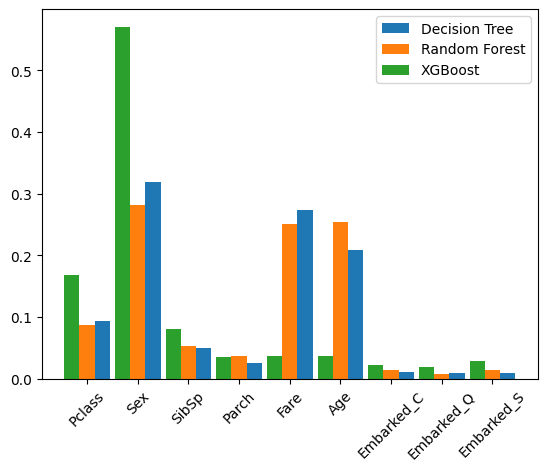

In [42]:
feature_importances_DT = dt_model.feature_importances_
feature_importances_RF = rf_model.feature_importances_
feature_importances_XGB = xgb_model.feature_importances_

utils.plot_feature_importances([feature_importances_DT, feature_importances_RF, feature_importances_XGB], ['Decision Tree', 'Random Forest', 'XGBoost'], independent_vars)

## ✨ Questions ✨

4. What are the three most important features?
5. Do the three models agree on these three most important features? What are the differences?
6. Why do you think these differences exist?

### Answers

*Write your answers here.*



## Model comparison

### Method 1: Confidence intervals

The first method we are using to compare models train and evaluate the models N times and compute the 95% confidence intervals. 

In [43]:
# Evaluate the performance of the models n_times and store the evaluation results in accuracies and f1_scores
print(f"\n{'-'*5} Re-train and re-evaluate method {'-'*5}")
time_before = time()
n_times = 30
accuracies = dict()
f1_scores = dict()
for _ in range(n_times):
    (temp_X_train, temp_y_train), (temp_X_test, temp_y_test) = utils.split_dataset(dataset,
                            independent_vars, dependent_var,
                            proportion_of_test_set, random_state=None)
    dt_model = DecisionTreeClassifier(random_state=None)
    dt_model.fit(temp_X_train, temp_y_train)
    rf_model = RandomForestClassifier(random_state=None)
    rf_model.fit(temp_X_train, temp_y_train)
    xgb_model = xgb.XGBClassifier(random_state=None)
    xgb_model.fit(temp_X_train, temp_y_train)
    models = [dt_model, rf_model, xgb_model]
    metrics = utils.evaluate_models(models, temp_X_test, temp_y_test, verbose=False)
    for model_name, (accuracy, f1_score_value) in zip(models, metrics):
        accuracies.setdefault(model_name.__class__.__name__, []).append(accuracy)
        f1_scores.setdefault(model_name.__class__.__name__, []).append(f1_score_value)


----- Re-train and re-evaluate method -----


We now compute and visualize the confidence intervals of each model and metric.

In [44]:
for model_name in accuracies:
    accuracy_mean, accuracy_confidence_interval = utils.confidence_interval(accuracies[model_name], 0.95)
    f1_score_mean, f1_score_confidence_interval = utils.confidence_interval(f1_scores[model_name], 0.95)
    print(f"Model: {model_name}.")
    print(f"\tAccuracy mean: {accuracy_mean:.4f}. CI: {accuracy_confidence_interval}.")
    print(f"\tF1 Score: {f1_score_mean:.4f}. CI: {f1_score_confidence_interval}.")

print(f"Time elapsed: {time() - time_before:.2f} seconds.")

Model: DecisionTreeClassifier.
	Accuracy mean: 0.7706. CI: (0.7580496897346599, 0.7831048726489528).
	F1 Score: 0.7003. CI: (0.6813976916278623, 0.7192024798353727).
Model: RandomForestClassifier.
	Accuracy mean: 0.8060. CI: (0.7940706117914111, 0.8178474515233003).
	F1 Score: 0.7404. CI: (0.7234469066533583, 0.7572786328303299).
Model: XGBClassifier.
	Accuracy mean: 0.8056. CI: (0.7942345122820551, 0.8169386720754872).
	F1 Score: 0.7400. CI: (0.7229058252508257, 0.7570706953632488).
Time elapsed: 7.94 seconds.


## ✨ Questions ✨

7. Are there differences with the previous values?
8. Why?
9. What of the two previous comparison methods do you think is better?
10. Just comparing the means, is there any modification of the best, average, and worst models?
11. Are there significant differences between the models?

### Answers

*Write your answers here.*



### Method 2: Bootstrap

We do not retrain the model. Instead, we use bootstrap on the test set to estimate the confidence intervals.

*Notice*. This method is used when retraining the models is so expensive that we cannot afford to retrain them N times. A common example is a deep learning model that takes hours to train. In this case, we use the test set to compute the confidence intervals of the metrics using a method called bootstrapping. 

In [45]:
print(f"\n{'-'*5} Bootstrapping method {'-'*5}")
time_before = time()

dt_model = DecisionTreeClassifier(random_state=random_state)
dt_model.fit(X_train, y_train)
rf_model = RandomForestClassifier(random_state=random_state)
rf_model.fit(X_train, y_train)
xgb_model = xgb.XGBClassifier(random_state=random_state)
xgb_model.fit(X_train, y_train)
models = [dt_model, rf_model, xgb_model]

# Perform bootstrapping
n_bootstrap_samples = 10_000
bootstrap_accuracies = dict()
bootstrap_f1_scores = dict()
for _ in range(n_bootstrap_samples):
    # Resample with replacement, both X_test and the corresponding y_test at the same time (important)
    resampled_X_test, resampled_y_test = resample(X_test, y_test, replace=True)
    # Calculate the metrics for each model and store it in the two dictionaries
    for model in models:
        resampled_y_pred = model.predict(resampled_X_test)
        accuracy = accuracy_score(resampled_y_test, resampled_y_pred)
        f1_score_value = f1_score(resampled_y_test, resampled_y_pred)
        bootstrap_accuracies.setdefault(model.__class__.__name__, []).append(accuracy)
        bootstrap_f1_scores.setdefault(model.__class__.__name__, []).append(f1_score_value)

# Compute and visualize the confidence intervals of each model and metric
for model_name in bootstrap_accuracies:
    accuracy_mean = np.mean(bootstrap_accuracies[model_name])
    accuracy_confidence_interval = (np.percentile(bootstrap_accuracies[model_name], 2.5), np.percentile(bootstrap_accuracies[model_name], 97.5))
    f1_score_mean = np.mean(bootstrap_f1_scores[model_name])
    f1_score_confidence_interval = (np.percentile(bootstrap_f1_scores[model_name], 2.5), np.percentile(bootstrap_f1_scores[model_name], 97.5))
    print(f"Model: {model_name}.")
    print(f"\tAccuracy mean: {accuracy_mean:.4f}. CI: {accuracy_confidence_interval}.")
    print(f"\tF1 Score: {f1_score_mean:.4f}. CI: {f1_score_confidence_interval}.")

print(f"Time elapsed: {time() - time_before:.2f} seconds.")


----- Bootstrapping method -----
Model: DecisionTreeClassifier.
	Accuracy mean: 0.7381. CI: (0.6759776536312849, 0.7988826815642458).
	F1 Score: 0.6560. CI: (0.5581395348837209, 0.7448275862068966).
Model: RandomForestClassifier.
	Accuracy mean: 0.8047. CI: (0.7486033519553073, 0.8603351955307262).
	F1 Score: 0.7395. CI: (0.6504065040650406, 0.8188976377952756).
Model: XGBClassifier.
	Accuracy mean: 0.7935. CI: (0.7318435754189944, 0.8491620111731844).
	F1 Score: 0.7118. CI: (0.6166666666666667, 0.7969924812030075).
Time elapsed: 190.68 seconds.


## ✨ Questions ✨

12. Are there differences with the previous values? Why?
13. What method takes longer? Why?
14. In deep learning scenarios, do you think there will be similar execution-time differences?

### Answers

*Write your answers here.*

